# Deep Learning for Femur Segmentation

This is a personal project to create a UNet model that can segment fluoroscopy images of femurs. Input and output images have been omitted from display as the dataset used is not public. <br>

Code in this notebook is referenced from the following repo and also assistance from others: https://github.com/Mostafa-wael/U-Net-in-PyTorch/blob/main/U_Net.ipynb 

Changes made from example code above include:
1) Modifications to work with custom femur dataset <br>
2) Addition of train loss plot <br>
3) Implementation of metrics <br> 
4) Export to ONNX and mean inference time <br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import reduce
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from tqdm import tqdm
import torch
import glob
import cv2
import pickle
from multiprocessing import Pool
from byol_pytorch import BYOL
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\Io\anaconda3\envs\env_torch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Io\anaconda3\envs\env_torch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\Io\anaconda3\envs\env_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

These helper functions are used to create the Dataset.

In [2]:
def square_crop(img):
    # crops an image to have its height match its width.
    # crop is done only on the larger dim.

    h = None
    w = None
    
    if len(img.shape) == 3:
        h, w, _ = img.shape
    else:
        h, w = img.shape
    
    if h > w:
        diff = int(h - w) // 2
        img = img[diff:h-diff:, :]
    else:
        diff = int(w - h) // 2
        img = img[:, diff:w-diff]

    return img


def load_image(image_path, mode, image_size, threshold=False):
    # thresholding fixes JPG artifacts
    img = cv2.imread(image_path, mode)
    img = square_crop(img)
    if threshold:
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    if image_size != -1:
        img = cv2.resize(img, (image_size, image_size))
    return img


### Creating Dataset

In [8]:
class FemurDataset(Dataset):

    def __init__(self, image_size=-1):
        super().__init__()

        self.img_size  = image_size
        self.transform = transforms.RandomInvert(p=0.05)

        # load paths from pickle files
        image_paths = []
        label_paths = []

        image_paths = glob.glob(r'C:\dramadas\data\femur_seg_images\*', recursive=True)
        label_paths = glob.glob(r'C:\dramadas\data\femur_seg_masks\*', recursive=True)

        self.image_paths = image_paths
        self.label_paths = label_paths
        assert len(self.image_paths) == len(self.label_paths)
        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
 
        image     = load_image(self.image_paths[idx], cv2.IMREAD_COLOR,     self.img_size, False)

        gt_mask   = load_image(self.label_paths[idx], cv2.IMREAD_GRAYSCALE, self.img_size, True)
 
        image_t   = torch.Tensor(image/(255.0)).permute(2,0,1)

        gt_mask_t = torch.Tensor(gt_mask/ 255.0).unsqueeze(0)

 
        return [image_t, gt_mask_t]


In [9]:
ds = FemurDataset(
    image_size=256,
)

image, gt_mask = ds[0]

print('Image size:        ',  image.size())
print('GT Mask size:      ',  gt_mask.size())

Image size:         torch.Size([3, 256, 256])
GT Mask size:       torch.Size([1, 256, 256])


Note: Check for mins and max to see if normalization is needed

In [10]:
torch.min(image)

tensor(0.)

In [11]:
torch.max(image)

tensor(1.)

## View images here

In [12]:
image = image.permute(1,2,0)
print(image.shape)
# plt.imshow(image)
# plt.show()

torch.Size([256, 256, 3])


In [13]:
image = gt_mask.squeeze()
# plt.imshow(image)

### Dataloader creation

The train/test split used was 0.1.

In [14]:
batch_size = 2

# split into train/test
test_size  = int(len(ds) * 0.1)
train_size = len(ds) - test_size
print('Train dataset size: {:,}'.format(train_size))
print('Test dataset size:  {:,}'.format(test_size))
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=batch_size, shuffle=True)

Train dataset size: 1,053
Test dataset size:  116


## Model Training Function

In [7]:
def train_model(model, optimizer, num_epochs=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_loss = 1e10
    loss_fn    = torch.nn.BCEWithLogitsLoss()
    train_loss = 0.0
    all_train_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])

        model.train()  # Set model to training mode

        metrics = defaultdict(float)
        epoch_samples = 0

        for i, (image, gt_mask) in enumerate(tqdm(train_loader)):
            inputs = image.to(device)
            labels = gt_mask.to(device)

            # forward
            outputs = model(inputs)
            loss = loss_fn(outputs.to(device), labels)

            # zero the parameter gradients
            optimizer.zero_grad()
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)

            #print_metrics(metrics, epoch_samples)
            epoch_loss = metrics['loss'] / epoch_samples
            
            # update train loss
            train_loss = train_loss + ((1 / (i + 1)) * (loss - train_loss))

        train_loss = train_loss / len(train_loader) 
        print('Train loss: {:,}'.format(train_loss))
        all_train_losses.append(train_loss.item())

    plt.plot(all_train_losses)
    return model



## UNet Model Definition

In [21]:
# First, the necessary modules are imported from the torch and torchvision packages, including the nn module for building neural networks and the pre-trained models provided in torchvision.models. 
# The relu function is also imported from torch.nn.functional.
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu


# Then, a custom class UNet is defined as a subclass of nn.Module. 
# The __init__ method initializes the architecture of the U-Net by defining the layers for both the encoder and decoder parts of the network. 
# The argument n_class specifies the number of classes for the segmentation task.
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) 


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train model


Epoch 0/49
----------
LR 0.0001


100%|██████████| 527/527 [00:14<00:00, 37.34it/s]


Train loss: 0.000805570394732058
Epoch 1/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.33it/s]


Train loss: 0.0006636857870034873
Epoch 2/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.35it/s]


Train loss: 0.0005407611606642604
Epoch 3/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.24it/s]


Train loss: 0.00040144388913176954
Epoch 4/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.29it/s]


Train loss: 0.0002845249546226114
Epoch 5/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.07it/s]


Train loss: 0.00021727022249251604
Epoch 6/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.20it/s]


Train loss: 0.00016706286987755448
Epoch 7/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.03it/s]


Train loss: 0.00012001071445411071
Epoch 8/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.23it/s]


Train loss: 0.00011007461580447853
Epoch 9/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.63it/s]


Train loss: 7.555248885182664e-05
Epoch 10/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.71it/s]


Train loss: 8.314515434904024e-05
Epoch 11/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.06it/s]


Train loss: 6.827019387856126e-05
Epoch 12/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.03it/s]


Train loss: 5.670906466548331e-05
Epoch 13/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.97it/s]


Train loss: 7.568490400444716e-05
Epoch 14/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.96it/s]


Train loss: 4.55875342595391e-05
Epoch 15/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.14it/s]


Train loss: 3.8926478737266734e-05
Epoch 16/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.00it/s]


Train loss: 3.682324677356519e-05
Epoch 17/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.02it/s]


Train loss: 5.768265327787958e-05
Epoch 18/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.89it/s]


Train loss: 5.9928453993052244e-05
Epoch 19/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.08it/s]


Train loss: 3.436277256696485e-05
Epoch 20/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.98it/s]


Train loss: 4.274718594388105e-05
Epoch 21/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.13it/s]


Train loss: 3.630372884799726e-05
Epoch 22/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.96it/s]


Train loss: 3.046568963327445e-05
Epoch 23/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.09it/s]


Train loss: 3.9794704207452014e-05
Epoch 24/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.91it/s]


Train loss: 4.320457446738146e-05
Epoch 25/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.89it/s]


Train loss: 2.639856029418297e-05
Epoch 26/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.94it/s]


Train loss: 2.651043178047985e-05
Epoch 27/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.50it/s]


Train loss: 3.6204954085405916e-05
Epoch 28/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 43.96it/s]


Train loss: 2.6404584787087515e-05
Epoch 29/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 45.05it/s]


Train loss: 2.0861984012299217e-05
Epoch 30/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.93it/s]


Train loss: 1.9780136426561512e-05
Epoch 31/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.82it/s]


Train loss: 1.8663144146557897e-05
Epoch 32/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.54it/s]


Train loss: 1.8136845028493553e-05
Epoch 33/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.82it/s]


Train loss: 1.825170693336986e-05
Epoch 34/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.94it/s]


Train loss: 3.71872192772571e-05
Epoch 35/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.55it/s]


Train loss: 4.301784429117106e-05
Epoch 36/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.71it/s]


Train loss: 3.054683475056663e-05
Epoch 37/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.65it/s]


Train loss: 1.963441536645405e-05
Epoch 38/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.75it/s]


Train loss: 1.56544065248454e-05
Epoch 39/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.70it/s]


Train loss: 1.4488558917946648e-05
Epoch 40/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.65it/s]


Train loss: 1.4409634786716197e-05
Epoch 41/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.69it/s]


Train loss: 1.4592305888072588e-05
Epoch 42/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.69it/s]


Train loss: 1.4719992577738594e-05
Epoch 43/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.64it/s]


Train loss: 1.4556893802364357e-05
Epoch 44/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.82it/s]


Train loss: 1.4544460100296419e-05
Epoch 45/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.64it/s]


Train loss: 4.626567169907503e-05
Epoch 46/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.70it/s]


Train loss: 2.8133335945312865e-05
Epoch 47/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.54it/s]


Train loss: 1.4556791029463056e-05
Epoch 48/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.50it/s]


Train loss: 1.2657671504712198e-05
Epoch 49/49
----------
LR 0.0001


100%|██████████| 527/527 [00:11<00:00, 44.55it/s]


Train loss: 1.1976357200182974e-05


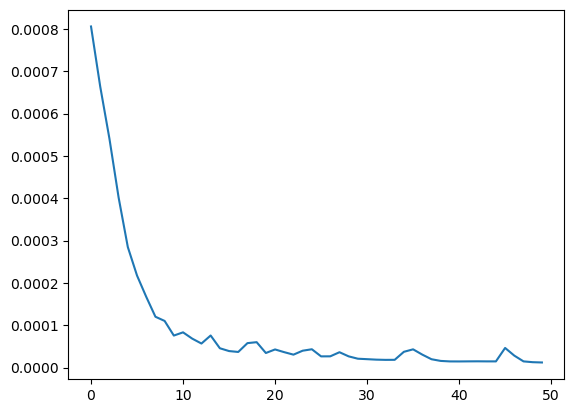

In [12]:
num_class = 1 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

model = train_model(model, optimizer_ft, num_epochs=50)

### Save model checkpoint here

In [30]:
## Save the model here
import torch
import torchvision.models as models

In [31]:
torch.save(model.state_dict(), 'model_weights.pth')

In [34]:
## Load the model here
model = UNet(1) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

### Evaluate model for 1 test image



In [13]:
model.eval()  # Set model to the evaluation mode

test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=1, shuffle=True) # this line is repeated

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print("inputs shape", inputs.shape)
print("labels shape", labels.shape)


inputs shape torch.Size([1, 3, 256, 256])
labels shape torch.Size([1, 1, 256, 256])


In [14]:
# Predict
pred = model(inputs)
# pred = pred.to(device)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred_seg = pred.data.cpu().numpy()
print("predicted mask shape", pred.shape)
pred_seg = (pred_seg > 0.5).astype(np.uint8)
print(pred_seg.shape)
inputs = inputs.squeeze(0)
print("inputs shape", inputs.shape)
print("Labels shape", labels.cpu().numpy().shape)

predicted mask shape torch.Size([1, 1, 256, 256])
(1, 1, 256, 256)
inputs shape torch.Size([3, 256, 256])
Labels shape (1, 1, 256, 256)


### Metrics For Test Image

In [17]:
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryF1Score

Metrics from here: https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html

In [18]:
labels = (labels>0.5).float()

In [19]:
metric1 = BinaryAccuracy().to(device)
metric1(pred, labels)

tensor(0.9891, device='cuda:0')

In [20]:
metric2 = BinaryPrecision().to(device)
metric2(pred,labels)

tensor(0.9882, device='cuda:0')

In [21]:
metric3 = BinaryRecall().to(device)
metric3(pred,labels)

tensor(0.9654, device='cuda:0')

In [22]:
metric4 = BinaryF1Score().to(device)
metric4(pred,labels)

tensor(0.9767, device='cuda:0')

## View Test Image

### Original mask

In [23]:
labels = labels.cpu()
labels = labels.squeeze()
print(labels.shape)

# plt.imshow(labels)
# plt.show()

torch.Size([256, 256])


### Model Generated Mask

In [24]:
pred_seg = pred_seg.squeeze()
print(pred_seg.shape)

# plt.imshow(pred_seg)
# plt.show()

(256, 256)


### Original image

In [25]:
inputs = inputs.cpu()
#image = inputs/(255.0)
image = inputs.permute(1,2,0)
print(image.shape)

# plt.imshow(image)
# plt.show()

torch.Size([256, 256, 3])


### Image with mask overlay

Code taken from here to do the overlays: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib

In [26]:
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# create dummy data
inputs = inputs.cpu()
#image = inputs/(255.0)
image = inputs.permute(1,2,0)
zvals = image
zvals2 = pred_seg

# generate the colors for your colormap
color1 = colorConverter.to_rgba('black')
color2 = colorConverter.to_rgba('yellow')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['red','green'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

# img2 = plt.imshow(zvals, interpolation='nearest', cmap=cmap1, origin='upper')
# img3 = plt.imshow(zvals2, interpolation='nearest', cmap=cmap2, origin='upper')

# plt.show()

## Evaluate model for all test images

In [27]:
accuracies = []
precisions = []
recalls = []
f1scores = []
for i, (image, gt_mask) in enumerate(tqdm(test_loader)):
    inputs = image.to(device)
    labels = gt_mask.to(device)

    outputs = model(inputs)
    
    #Binarize target mask
    labels = (labels>0.5).float()

    #Accuracy
    metric1 = BinaryAccuracy().to(device)
    acc = metric1(outputs, labels)
    accuracies.append(acc.item())

    
    #Precision
    metric2 = BinaryPrecision().to(device)
    prec = metric2(outputs, labels)
    precisions.append(prec.item())
    
    #Recall
    metric3 = BinaryRecall().to(device)
    rec = metric3(outputs, labels)
    recalls.append(rec.item())

    #F1
    metric4 = BinaryF1Score().to(device)
    f1_s = metric4(outputs, labels)
    f1scores.append(f1_s.item())



100%|██████████| 116/116 [00:02<00:00, 42.56it/s]


In [28]:
print(np.average(accuracies))
print(np.average(precisions))
print(np.average(recalls))
print(np.average(f1scores))

0.990734758048222
0.9817432252497509
0.96905434080239
0.9738472926205602


### To see summary/parameters of model

In [ ]:
import pytorch_model_summary as pms

In [ ]:
model = UNet(2)
print(pms.summary(
            model,
            torch.zeros((8, 3, 256, 256)),
            show_input=True
        ))

## Exporting to ONNX

In [ ]:
# Some standard imports
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import onnxruntime
import onnx

In [ ]:
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True).to(device)
torch_out = model(x)
torch.onnx.export(model, 
                  x, 
                  "UNet.onnx",
                 export_params = True,
                 opset_version=10,
                 do_constant_folding=True,
                 input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
onnx_model = onnx.load("UNet.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
ort_session = onnxruntime.InferenceSession("UNet.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}

start_time = time.perf_counter()
for i in range(1000):
    ort_outs = ort_session.run(None, ort_inputs)
end_time = time.perf_counter()
print("Mean inference time", (end_time - start_time)/1000)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [ ]:
print("Mean inference time", (end_time - start_time)/1000)